In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import dask.dataframe as dd
from scipy.sparse import csr_matrix


In [2]:
scores = pd.read_csv('../data/ml-32m/ratings.csv')
#scores = pd.read_csv('../data/scores.csv')

In [22]:
scores['userId'].nunique()

200948

In [13]:
scores = scores[['userId', 'movieId', 'rating']]

In [14]:
scores

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0
...,...,...,...
32000199,200948,79702,4.5
32000200,200948,79796,1.0
32000201,200948,80350,0.5
32000202,200948,80463,3.5


/opt/anaconda3/envs/tp_2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/tp_2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/tp_2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/tp_2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

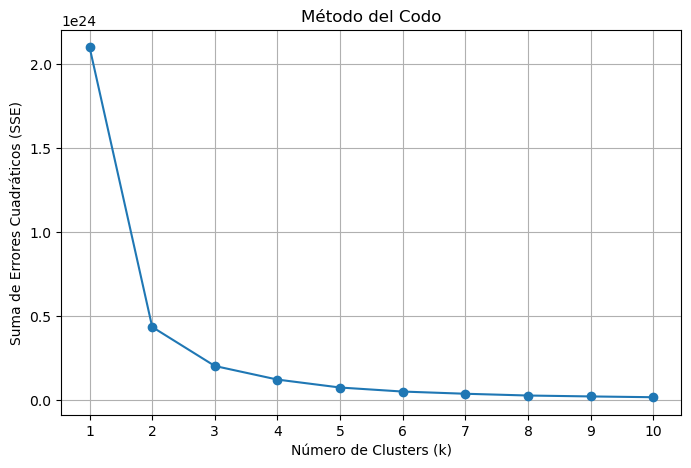

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Crear una lista para almacenar el SSE
sse = []
k_range = range(1, 11)  # Prueba valores de k de 1 a 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scores)  # Asegúrate de que X es tu matriz de características
    sse.append(kmeans.inertia_)  # Inertia es la suma de errores cuadrados

# Graficar el SSE contra k
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_range)
plt.grid()
plt.show()

In [15]:
kmeans = KMeans(n_clusters=5, random_state=42)
scores['cluster'] = kmeans.fit_predict(scores)

In [20]:
scores

,userId,movieId,rating,cluster
0,1,17,4.0,1
1,1,25,1.0,1
2,1,29,2.0,1
3,1,30,5.0,1
4,1,32,5.0,1
...,...,...,...,...
32000199,200948,79702,4.5,3
32000200,200948,79796,1.0,3
32000201,200948,80350,0.5,3
32000202,200948,80463,3.5,3
